In [ ]:
!pip install findspark

In [1]:
import findspark
findspark.init()

# Example: Linear Regression with Spark MLlib
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Initialize Spark Session
spark = SparkSession.builder.appName('MLlib Example').getOrCreate()

# Load sample data
data = [(1, 5.0, 20.0), (2, 10.0, 25.0), (3, 15.0, 30.0), (4, 20.0, 35.0)]
columns = ['ID', 'Feature', 'Target']
df = spark.createDataFrame(data, columns)

# Prepare data for modeling
assembler = VectorAssembler(inputCols=['Feature'], outputCol='Features')
df_transformed = assembler.transform(df)

# Train a linear regression model
lr = LinearRegression(featuresCol='Features', labelCol='Target')
model = lr.fit(df_transformed)

# Print model coefficients
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')

25/12/07 14:56:25 WARN Utils: Your hostname, ahmadyaa-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/12/07 14:56:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/07 14:56:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/07 14:56:51 WARN Instrumentation: [9f01860e] regParam is zero, which might cause numerical instability and overfitting.
25/12/07 14:56:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/12/07 14:56:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/12/07 14:56:55 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it

Coefficients: [0.9999999999999992]
Intercept: 15.000000000000009


In [2]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

# Contoh dataset
data = [
    (1, Vectors.dense([2.0, 3.0]), 0),
    (2, Vectors.dense([1.0, 5.0]), 1),
    (3, Vectors.dense([2.5, 4.5]), 1),
    (4, Vectors.dense([3.0, 6.0]), 0)
]

columns = ['ID', 'Features', 'Label']

df = spark.createDataFrame(data, columns)

# Train logistic regression model
lr = LogisticRegression(featuresCol='Features', labelCol='Label')
model = lr.fit(df)

# Display coefficients and summary
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')



Coefficients: [-12.262057937838394,4.087352269372807]
Intercept: 11.568912735310269


In [3]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.classification import LogisticRegression

# UDF untuk mengubah array menjadi DenseVector
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())

# Buat kolom features_vec yang dijamin VectorUDT
df_vec = df.withColumn("features_vec", to_vector("Features"))

lr = LogisticRegression(featuresCol='features_vec', labelCol='Label')
model = lr.fit(df_vec)

print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)

Coefficients: [-12.262057937838394,4.087352269372807]
Intercept: 11.568912735310269


In [4]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.clustering import KMeans

# Example dataset
data = [(1, [1.0, 1.0]), (2, [5.0, 5.0]), (3, [10.0, 10.0]), (4, [15.0, 15.0])]
columns = ['ID', 'Features']
df = spark.createDataFrame(data, columns)

# UDF convert features → DenseVector
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_vec = df.withColumn("features_vec", to_vector("Features"))

# Train clustering model
kmeans = KMeans(featuresCol='features_vec', k=2)
model = kmeans.fit(df_vec)

# Show cluster centers
centers = model.clusterCenters()
print("Cluster Centers:", centers)

[Stage 149:>                                                        (0 + 8) / 8]

Cluster Centers: [array([12.5, 12.5]), array([3., 3.])]


In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.datasets import load_iris
import pandas as pd

# 🔹 Start Spark
spark = SparkSession.builder.appName("Iris.csv").getOrCreate()

# 🔹 Load Iris dataset
iris = load_iris()
df_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
df_pd["label"] = iris.target   # class column

# Convert to Spark DataFrame
df = spark.createDataFrame(df_pd)

df.show(5)

25/12/07 15:08:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
|              4.6|             3.1|              1.5|             0.2|    0|
|              5.0|             3.6|              1.4|             0.2|    0|
+-----------------+----------------+-----------------+----------------+-----+
only showing top 5 rows



In [10]:
# Data Preparation
# Vectorize fitur numeric
assembler = VectorAssembler(
    inputCols=df.columns[:-1], 
    outputCol="features"
)
df_vec = assembler.transform(df)

# Convert label ke numeric index (just in case)
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
df_final = indexer.fit(df_vec).transform(df_vec)

# Split data
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

In [11]:
# Clasification Model (Random Forest)
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

model_rf = rf.fit(train_data)
pred = model_rf.transform(test_data)

pred.select("indexedLabel", "prediction", "probability").show(5)

+------------+----------+-------------+
|indexedLabel|prediction|  probability|
+------------+----------+-------------+
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
+------------+----------+-------------+
only showing top 5 rows



In [13]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# ===========================================
# Evaluator untuk Multi-Class
# ===========================================
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel",
    predictionCol="prediction",
    metricName="accuracy"
)

# ===========================================
# Model Random Forest
# ===========================================
rf = RandomForestClassifier(
    labelCol="indexedLabel",
    featuresCol="features"
)

# Train
model_rf = rf.fit(train_data)

pred = model_rf.transform(test_data)
pred.select("indexedLabel", "prediction", "probability").show(5)

# ===========================================
# Hyperparameter Tuning (Cross Validator)
# ===========================================
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 50])
             .addGrid(rf.maxDepth, [3, 5, 8])
             .build())

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

# Latih model CV
cv_model = cv.fit(train_data)

# Prediksi model terbaik
best_pred = cv_model.transform(test_data)
best_acc = evaluator.evaluate(best_pred)

print("\n=====================================")
print("Best Model Performance")
print("Accuracy:", round(best_acc, 4))
print("=====================================")

# ===========================================
# Hyperparameter terbaik
# ===========================================
bestModel = cv_model.bestModel

print("\nBest Model Parameters:")
print(" - numTrees :", bestModel.getNumTrees)
print(" - maxDepth :", bestModel.getOrDefault('maxDepth'))


+------------+----------+-------------+
|indexedLabel|prediction|  probability|
+------------+----------+-------------+
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
|         0.0|       0.0|[1.0,0.0,0.0]|
+------------+----------+-------------+
only showing top 5 rows



25/12/07 15:12:57 WARN CacheManager: Asked to cache already cached data.
25/12/07 15:12:57 WARN CacheManager: Asked to cache already cached data.



Best Model Performance
Accuracy: 1.0

Best Model Parameters:
 - numTrees : 10
 - maxDepth : 3


Confusion Matrix:
[[13  0  0]
 [ 0  8  0]
 [ 0  0 13]]


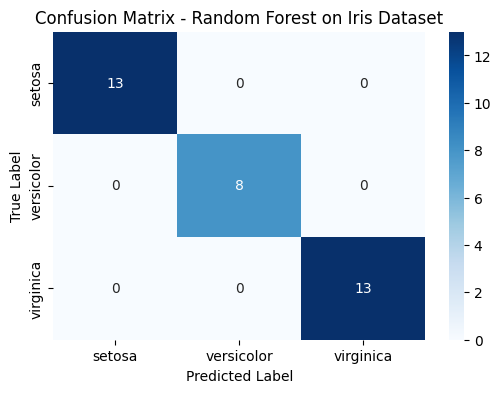

In [15]:
# Confusion Matrix dan Visualisasi
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil hasil prediksi ke Pandas DataFrame
pred_pd = best_pred.select("indexedLabel", "prediction").toPandas()

# Hitung Confusion Matrix
cm = confusion_matrix(pred_pd['indexedLabel'], pred_pd['prediction'])

print("Confusion Matrix:")
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)

plt.title("Confusion Matrix - Random Forest on Iris Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()